In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data
tmp = pd.read_excel('EURHUF_TRB.xlsx')
tmp = tmp.rename(columns={'Date (GMT)': 'index'})
df = tmp['Last']
df.index = tmp['index']
df.head()

index
2022-01-25 16:00:00    358.460
2022-01-25 17:00:00    359.060
2022-01-25 18:00:00    359.155
2022-01-25 19:00:00    358.865
2022-01-25 20:00:00    358.515
Name: Last, dtype: float64

In [3]:
class Bollinger:
    
    def __init__(self, data:pd.Series, sma_period:int=20, std_multiplier:float=2):
        self.data = pd.DataFrame(data.rename('price'))
        self._sma_period = sma_period
        self._std_multiplier = std_multiplier
        
        self.data['sma'] = self.data.rolling(self._sma_period).mean()
        self.data['std'] = self.data['price'].rolling(self._sma_period).std()
        self.data['bollinger_lower_bound'] = self.data['sma'] - self._std_multiplier * self.data['std']
        self.data['bollinger_upper_bound'] = self.data['sma'] + self._std_multiplier * self.data['std']
        self.data['upper_breakpoint'] = self.data[(self.data['price']>self.data['bollinger_upper_bound'])]['price']
        self.data['lower_breakpoint'] = self.data[(self.data['price']<self.data['bollinger_lower_bound'])]['price']
        
        self.data_length = self.data.shape[0]
        self.ext_up = self.data['upper_breakpoint'].count()
        self.ext_low = self.data['lower_breakpoint'].count()
        
        
    def statistics(self):
        col1_length = 35
        print(f"{'Length of time series: ' :>{col1_length}}{self.data_length}")
        print(f"{'SMA period: ':>{col1_length}}{self._sma_period}")
        print(f"{'Std multiplier: ':>{col1_length}}{self._std_multiplier}")
        print(f"{'Number of upper breakpoints: ':>{col1_length}}{self.ext_up} ({round(100*self.ext_up/self.data_length,2)}%)")
        print(f"{'Number of lower breakpoints: ':>{col1_length}}{self.ext_low} ({round(100*self.ext_low/self.data_length,2)}%)")
        print(f"{'Ratio of breakpoints: ':>{col1_length}}{round((self.ext_up+self.ext_low)/self.data_length*100,2)}%")
        
        
    def plot(self, plot_sma:bool=True, plot_bollinger_bound:bool=True, plot_long_sma:int=None, plot_breakpoints:bool=True):
        fig, ax = plt.subplots(1,1,figsize=(16,16))
        columns = ['price']
        legend_labels = ['Price']
        
        if plot_sma:
            columns.append('sma')
            legend_labels.append(f'Simple Moving Average (period={self._sma_period})')
        
        if plot_bollinger_bound:
            columns.append('bollinger_lower_bound')
            legend_labels.append('Bollinger lower bound')
            columns.append('bollinger_upper_bound')
            legend_labels.append('Bollinger lower bound')
        
        if plot_long_sma:
            self.data['long_sma'] = self.data['price'].rolling(plot_long_sma).mean()
            columns.append('long_sma')
            legend_labels.append(f'Long SMA (period={plot_long_sma})')
        
        if plot_breakpoints:
            columns.append('upper_breakpoint')
            legend_labels.append('Upper breakpoint')
            columns.append('lower_breakpoint')
            legend_labels.append('Lower breakpoint')
            
        # Plot
        sns.lineplot(data=self.data[columns], ax=ax, legend=False)
        
        # Style
        ax.lines[columns.index('price')].set(linestyle='-', color="C0")
        
        if plot_sma:
            ax.lines[columns.index('sma')].set(linestyle='-', color='orange')
        
        if plot_bollinger_bound:
            ax.fill_between(self.data.index, self.data['bollinger_lower_bound'], self.data['bollinger_upper_bound'], alpha=0.1)
            ax.lines[columns.index('bollinger_lower_bound')].set(linestyle='--', color='green')
            ax.lines[columns.index('bollinger_upper_bound')].set(linestyle='--', color='red')
        
        if plot_long_sma:
            ax.lines[columns.index('long_sma')].set(linestyle='-', color='C9')
        
        if plot_breakpoints:
            ax.lines[columns.index('upper_breakpoint')].set(linestyle='', marker='o', markersize=10, color='red')
            ax.lines[columns.index('lower_breakpoint')].set(linestyle='', marker='o', markersize=10, color='green')
              
        # Legend
        ax.legend(legend_labels)

In [4]:
def trade_algo1(df, balance:int=1):
    """
        Algo based on Bollinger bounds
        - Buy below of lower bound
        - Sell above the upped bound
    """
    to_buy = True
    df_tmp = df.copy()
    df_tmp = df_tmp.reset_index()
    df_tmp['indicator'] = np.nan
    df_tmp['balance_ccy1'] = np.nan
    df_tmp['balance_ccy2'] = np.nan
    df_tmp['balance_local'] = np.nan
    
    # main loop
    for idx in range(df_tmp.shape[0]):
        # set balance
        df_tmp.at[idx,'balance_ccy1'] = 0 if idx==0 else df_tmp.at[idx-1,'balance_ccy1']
        df_tmp.at[idx,'balance_ccy2'] = balance if idx==0 else df_tmp.at[idx-1,'balance_ccy2']

        # set indicator
        if to_buy:
            if df_tmp.at[idx,'lower_breakpoint']>0:
                df_tmp.at[idx,'indicator'] = 1
                to_buy = False
        else:
            if df_tmp.at[idx,'upper_breakpoint']>0:
                df_tmp.at[idx,'indicator'] = -1
                to_buy = True

        # action
        if df_tmp.at[idx,'indicator'] > 0 and df_tmp.at[idx,'balance_ccy2'] > 0:
            # buy
            df_tmp.at[idx,'balance_ccy1'] = df_tmp.at[idx,'balance_ccy2'] / df_tmp.at[idx,'lower_breakpoint']
            df_tmp.at[idx,'balance_ccy2'] = 0
        elif df_tmp.at[idx,'indicator'] < 0 and df_tmp.at[idx,'balance_ccy1'] > 0:
            # sell
            df_tmp.at[idx,'balance_ccy2'] = df_tmp.at[idx,'balance_ccy1'] * df_tmp.at[idx,'upper_breakpoint']
            df_tmp.at[idx,'balance_ccy1'] = 0
        else:
            if idx > 0:
                df_tmp.at[idx,'balance_ccy1'] = df_tmp.at[idx-1,'balance_ccy1']
                df_tmp.at[idx,'balance_ccy2'] = df_tmp.at[idx-1,'balance_ccy2']
                
        # set local balance
        df_tmp.at[idx,'balance_local'] = df_tmp.at[idx,'balance_ccy1'] * df_tmp.at[idx,'price'] + df_tmp.at[idx,'balance_ccy2']
    
    return df_tmp

In [5]:
b = Bollinger(df.tail(1000), 20, 2.5)

In [6]:
b.statistics()

            Length of time series: 1000
                       SMA period: 20
                   Std multiplier: 2.5
      Number of upper breakpoints: 35 (3.5%)
      Number of lower breakpoints: 16 (1.6%)
             Ratio of breakpoints: 5.1%


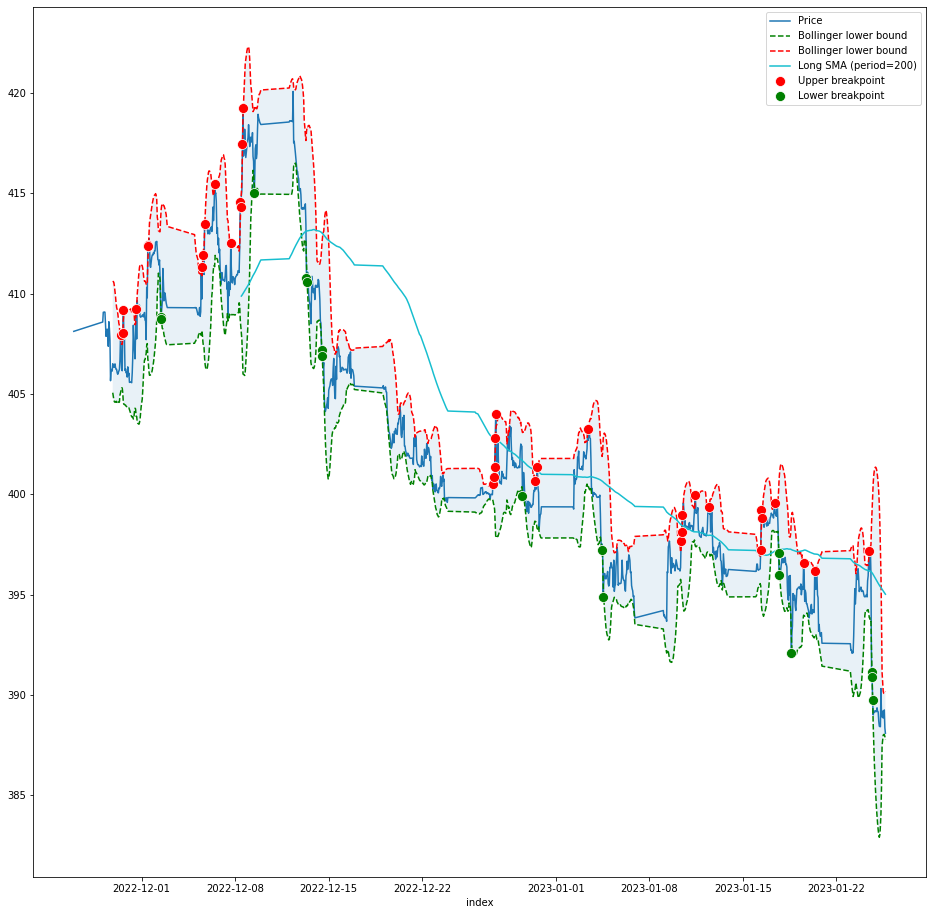

In [7]:
b.plot(plot_bollinger_bound=True,
       plot_sma=False,
       plot_breakpoints=True,
       plot_long_sma=200)

<AxesSubplot:>

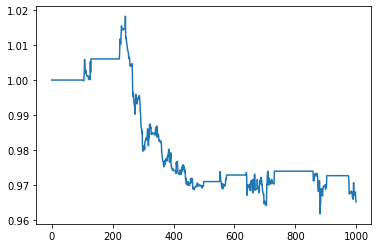

In [8]:
res1 = trade_algo1(b.data)
res1['balance_local'].plot()